# Pytorch Workflow

Let's explore an example PyTorch end-to-end workflow

In [2]:
what_were_covering = {1: "data (prepare and load)", 
                      2: "build model",
                      3: "fitting the model to data (training)",
                      4: "making predictions and evaluting a model (inference)",
                      5: "saving and loading a model",
                      6: "putting it all together"}




what_were_covering

{1: 'data (prepare and load)',
 2: 'build model',
 3: 'fitting the model to data (training)',
 4: 'making predictions and evaluting a model (inference)',
 5: 'saving and loading a model',
 6: 'putting it all together'}

In [118]:
import torch
from torch import nn # nn contains all of PyTorch's building blocks for neural networks
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Check PyTorch version
torch.__version__

'2.8.0+cpu'

## 1. Data (preparing and loading)

Data can be almost anything... in machine learning.

* Excel spreadsheet
* Images of any kind
* Videos (YouTube has lots of data...)
* Audio like songs or podcasts
* DNA
* Text

Machine learning is a game of two parts:
1. Get data into a numerical representation.
2. Build a model to learn patterns in that numerical representation.

To showcase this, let's create some *known* data using the linear regression formula.

We'll use a linear regression formula to make  a straight line with *known* **parameters**


In [4]:
# Create *known* parameters
# Y = a + bx
weight = 0.7    # b
bias = 0.3      # a

# Create data
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

X[:10], y[:10], len(X), len(y)

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]),
 50,
 50)

### Splitting data into training and tests sets (one of the most important concepts in machine learning in general)

Let's create a training and test set with our data



In [5]:
# Create train/test split
train_split = int(0.8 * len(X))

X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

How might we better visualize our data?

This is where the data explorer's motto comes in!

"Visualize, visualize, visualize!"

In [6]:
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
    """
    Plots training data, test data, and compares predictions
    """
    plt.figure(figsize=(10,7))

    # Plot training data in blue
    plt.scatter(train_data, train_labels, c='b', s=4, label='Training data')

    # Plot test data in green
    plt.scatter(test_data, test_labels, c='g', s=4, label='Testing data')

    # Are there predicitons?
    if predictions is not None:
        # Plot the predictions if they exist
        plt.scatter(test_data, predictions, c='r', s=4, label='Predictions')

    # Show the legend
    plt.legend(prop={'size': 14});

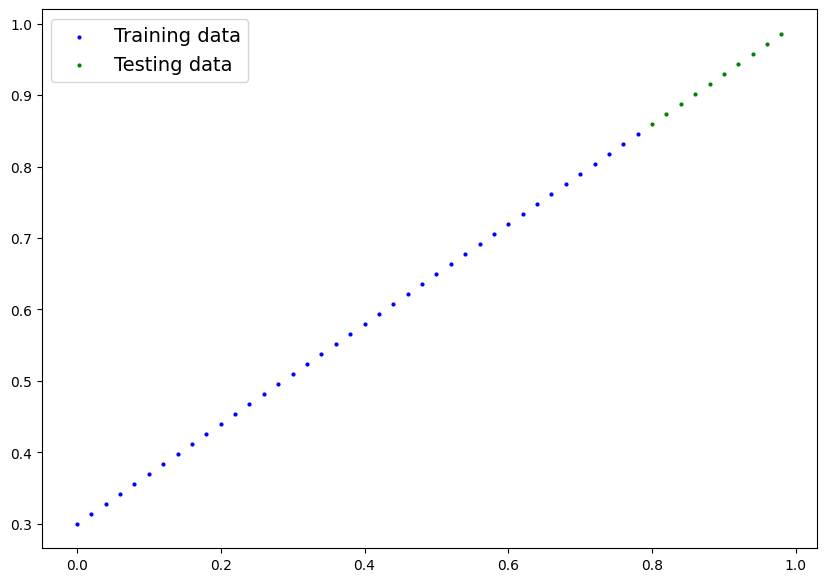

In [7]:
plot_predictions()

## 2. Build model

Our first PyTorch model!

What our model does:
* Start with random values (weight & bias)
* Look at training data and adjust the random values to better represent (or get closer to) the ideal values (the weight and & bias values we used to create the data)

How does it do so?

Through two main algorithms:
1. Gradient descent
2. Backpropagation


In [87]:
# Create linear regression model class
class LinearRegressionModel(nn.Module): # <- almost everything in PyTorch inherhits from nn.Module
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(1,
                                                requires_grad=True,
                                                dtype=torch.float))
        self.bias = nn.Parameter(torch.randn(1,
                                             requires_grad=True,
                                             dtype=torch.float))
        
    # Forward method to define the computation in the model
    def forward(self, x:torch.Tensor) -> torch.Tensor: # x is the input data (training data)
        return self.weights * x + self.bias # This is the linear regression formula

### PyTorch model building essentials

* torch.nn - contains all of the building for computational graphs (a neural network can be considered a computational graph)
* torch.nn.Parameter - what parameters should our model try and learn, oftern a PyTorch layer from torch.nn will set these for us
* torch.nn.Module - the base class for all neural network modules, if you subclass it, you should overwrite forward()
* torch.optim - this where the optimizers in PyTorch live, they will help with gradient descent
* def forward() - All nn.Module subclasses reqiure you to overwrite forward(), this method defines what happens in the forward computation

### Checking the contents of our PyTorch model

Now we've created a model, let's see what's inside...

So we can check our model parameters or what's inside our model using `.parameters()`

In [106]:
# Create a random seed
torch.manual_seed(42)

# Create an instance of the model (this is a subclass of nn.Module)
model_0 = LinearRegressionModel()

# Check our the parameters
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [89]:
# List named parameters
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

### Making prediciton using `torch.inference_mode()`

To check our model's predictive power, let's see how well it predicts `y_test` based on `X_test`.

When we pass data through our model, it's going to run it through the `forward()` method.

In [90]:
X_test, y_test
# Our model should take the x_test values as input and return the y_test values as output
# That is our ideal model

(tensor([[0.8000],
         [0.8200],
         [0.8400],
         [0.8600],
         [0.8800],
         [0.9000],
         [0.9200],
         [0.9400],
         [0.9600],
         [0.9800]]),
 tensor([[0.8600],
         [0.8740],
         [0.8880],
         [0.9020],
         [0.9160],
         [0.9300],
         [0.9440],
         [0.9580],
         [0.9720],
         [0.9860]]))

Inference mode turns off the gradient descent so no back propagation
It doesn't save the data so less memory being used

In [91]:
# Make predictions with model
with torch.inference_mode(): 
    y_preds = model_0(X_test)

y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

In [92]:
y_test

tensor([[0.8600],
        [0.8740],
        [0.8880],
        [0.9020],
        [0.9160],
        [0.9300],
        [0.9440],
        [0.9580],
        [0.9720],
        [0.9860]])

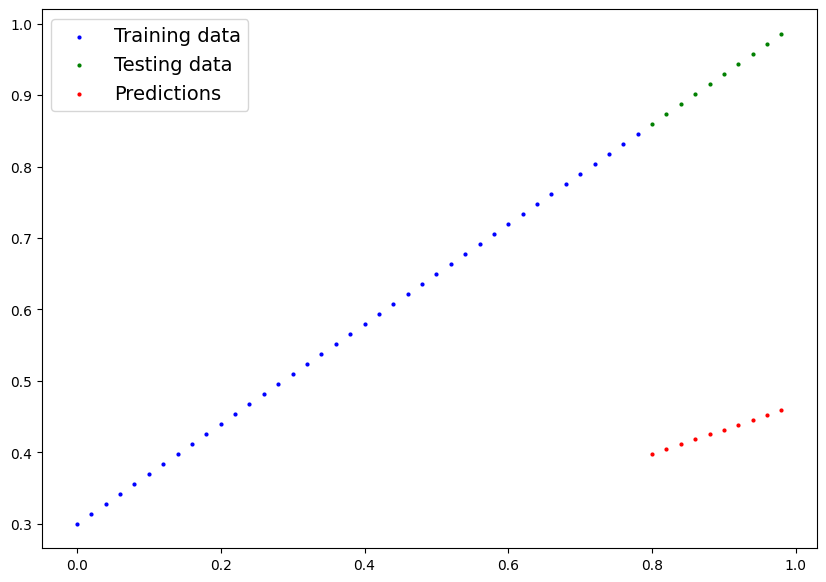

In [35]:
plot_predictions(predictions=y_preds)

## 3. Train model

The whole idea of training is for a model to move some *unknown* parameters (these may be random) to some *known* parameters

Or in other words from a poor representation of the data to a better representation of the data

One way to measure how poor or how wrong your models predictions are is to use a loss function

* Note: Loss fucntion may also be called cost function or criterion in different areas. For our case, we're going to refer to it as a loss function.

Things we need to train:

* **Loss function:** A function to measure how wrong your model's predictions are to the ideal outputs, lower is better.
* **Optimizer:** Takes into account the loss of a model and adjusts the model's parameters (e.g. weight & bias) to improve the loss function.

And specifically for PyTorch, we need:
* A training loop
* A testing loop


In [ ]:
# Check out our model's parameters (a parameter is a value that the model sets itself)
list(model_0.parameters()), (model_0.state_dict())

([Parameter containing:
  tensor([0.3367], requires_grad=True),
  Parameter containing:
  tensor([0.1288], requires_grad=True)],
 OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))]))

In [107]:
# Setup a loss function
loss_fn = nn.L1Loss()

# Setup an optimizer (stochastic gradient descent)
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.01) # lr = learning = possibly the most important hyperparameter you can set

### Building a training loop (and a testing loop) in PyTorch

A couple of things we need in a training loop:

0. Loop through the data
1. Forward pass (this involves data moving through our model's `forward()` functions) to make predictions on data - also called forward propagation
2. Calculate the loss (compare forward pass predictions to ground truth labels)
3. Optimizer zero grad
4. Loss backward - move backward through the network to calculate the gradients of each of the parameters of our model with respect to the loss (**backpropagation**)
5. Optimizer step - use the optimizer to adjust our model's parameters to try and improve the loss (**gradient descent**)

### PyTorch Optimization loop song!
It's train time!

do the forward pass,

calculate the loss

optimizer zero grad

losssssss backwards!

Optimizer step step step

Let's test now!

with torch no grad:

do the forward pass,

calculate the loss,

watch it go down down down!

**This song is not helpful**

In [108]:
# An epoch is one loop through the data... (this is a hyperparameter because we've set it ourselves)
epochs = 200

# Track different values
epoch_count = []
loss_values = []
test_loss_values = []

### Training
# 0. Loop through the data
for epoch in range(epochs):
    # Set the model to training mode
    model_0.train() # train mode in PyTorch sets all parameters that require gradients to require gradients

    # 1. Forward pass
    y_pred = model_0(X_train)

    # 2. Calculate the loss
    loss = loss_fn(y_pred, y_train)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Perform back propagation on the loss with respect to the parameters of the model
    loss.backward()

    # 5. Step the optimizer (perform gradient descent)
    optimizer.step() # by default how the optimizer changes will acculumate through the loop so...
                     # we have to zero them above in step 3 for the next iteration of the loop


    ### Testing
    model_0.eval() # turns off different settings in the model not needed for evaluation/testing
    with torch.inference_mode(): # turns off gradient tracking & a couple more things behind the scenes
        # 1. Do the forward pass
        test_pred = model_0(X_test)

        # 2. Calculate the loss
        test_loss = loss_fn(test_pred, y_test)

    # Pring out what's happening
    if epoch % 10 == 0:
        epoch_count.append(epoch)
        loss_values.append(loss)
        test_loss_values.append(test_loss)
        print(f"Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}")

print(model_0.state_dict())

Epoch: 0 | Loss: 0.31288138031959534 | Test loss: 0.48106518387794495
Epoch: 10 | Loss: 0.1976713240146637 | Test loss: 0.3463551998138428
Epoch: 20 | Loss: 0.08908725529909134 | Test loss: 0.21729660034179688
Epoch: 30 | Loss: 0.053148526698350906 | Test loss: 0.14464017748832703
Epoch: 40 | Loss: 0.04543796554207802 | Test loss: 0.11360953003168106
Epoch: 50 | Loss: 0.04167863354086876 | Test loss: 0.09919948130846024
Epoch: 60 | Loss: 0.03818932920694351 | Test loss: 0.08886633068323135
Epoch: 70 | Loss: 0.03476089984178543 | Test loss: 0.0805937647819519
Epoch: 80 | Loss: 0.03132382780313492 | Test loss: 0.07232122868299484
Epoch: 90 | Loss: 0.02788739837706089 | Test loss: 0.06473556160926819
Epoch: 100 | Loss: 0.024458957836031914 | Test loss: 0.05646304413676262
Epoch: 110 | Loss: 0.021020207554101944 | Test loss: 0.04819049686193466
Epoch: 120 | Loss: 0.01758546568453312 | Test loss: 0.04060482233762741
Epoch: 130 | Loss: 0.014155393466353416 | Test loss: 0.03233227878808975
Ep

In [ ]:
loss_values
# You have to turn loss_values into a numpy array because it's a tensor with a grad fn currently
# np.array(torch.tensor(loss_values).cpu().numpy())

[tensor(0.3129, grad_fn=<MeanBackward0>),
 tensor(0.1977, grad_fn=<MeanBackward0>),
 tensor(0.0891, grad_fn=<MeanBackward0>),
 tensor(0.0531, grad_fn=<MeanBackward0>),
 tensor(0.0454, grad_fn=<MeanBackward0>),
 tensor(0.0417, grad_fn=<MeanBackward0>),
 tensor(0.0382, grad_fn=<MeanBackward0>),
 tensor(0.0348, grad_fn=<MeanBackward0>),
 tensor(0.0313, grad_fn=<MeanBackward0>),
 tensor(0.0279, grad_fn=<MeanBackward0>),
 tensor(0.0245, grad_fn=<MeanBackward0>),
 tensor(0.0210, grad_fn=<MeanBackward0>),
 tensor(0.0176, grad_fn=<MeanBackward0>),
 tensor(0.0142, grad_fn=<MeanBackward0>),
 tensor(0.0107, grad_fn=<MeanBackward0>),
 tensor(0.0073, grad_fn=<MeanBackward0>),
 tensor(0.0039, grad_fn=<MeanBackward0>),
 tensor(0.0089, grad_fn=<MeanBackward0>),
 tensor(0.0089, grad_fn=<MeanBackward0>),
 tensor(0.0089, grad_fn=<MeanBackward0>)]

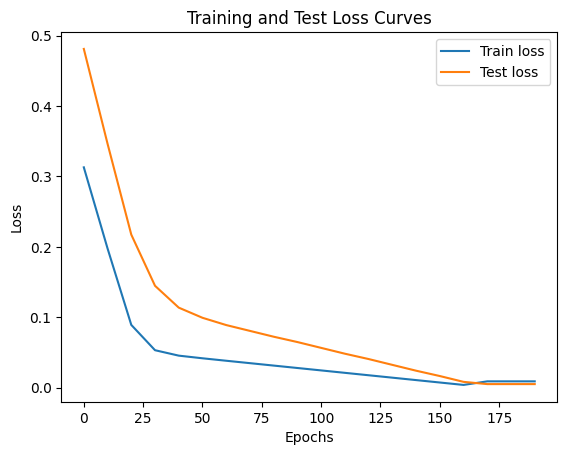

In [120]:
# Plot the loss curves
plt.plot(epoch_count, np.array(torch.tensor(loss_values).cpu().numpy()), label='Train loss')
plt.plot(epoch_count, test_loss_values, label='Test loss')
plt.title('Training and Test Loss Curves')
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()

In [101]:
with torch.inference_mode():
    new_y_preds = model_0(X_test)

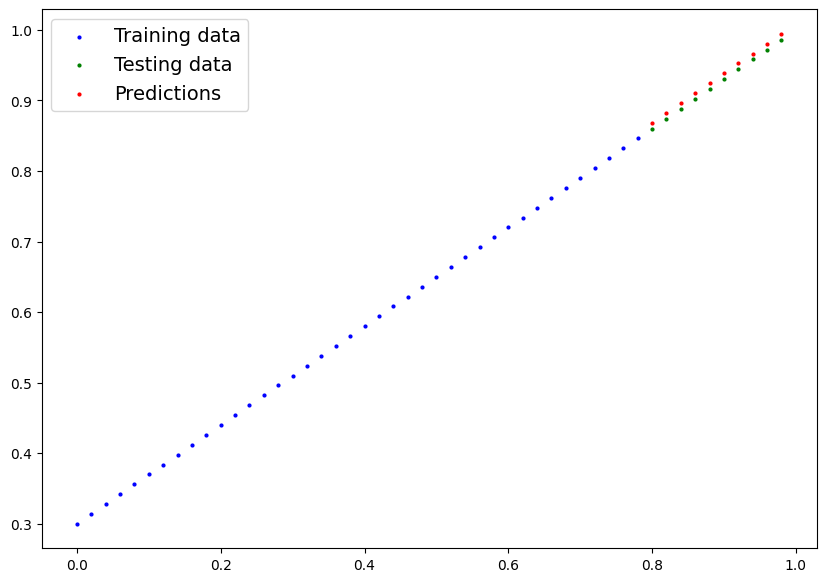

In [102]:
plot_predictions(predictions = new_y_preds)

## Saving a model in PyTorch

There are three main methods you should know about for saving and loading models in PyTorch.

1. `torch.save()` - allows you to save a PyTorch object in Python's pickle format
2. `torch.load()` - allows you to load a saved PyTorch object
3. `torch.nn.Module.load_state_dict()` - this allows you to load a model's saved state dictionary



In [124]:
# Saving our PyTorch model
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True) # exist_ok=True means that if it already exists, it won't throw an error

# 2. Create model save path
MODEL_NAME = '01_pytorch_workflow_model_0.pth'
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dictionary
print(f'Saving model to: {MODEL_SAVE_PATH}')
torch.save(obj=model_0.state_dict(), 
           f=MODEL_SAVE_PATH)

Saving model to: models\01_pytorch_workflow_model_0.pth
